In [1]:
# %matplotlib qt
import numpy as np
import scipy.constants as sc
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import motSim
import time
import matplotlib as mpl
import importlib
from matplotlib.ticker import FormatStrFormatter

$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$

In [2]:
muB=9.274e-24
AMU=1.66e-27
m171 = 171*AMU
Is556 = (0.139e-3)*(1e4)
Is399 = (59.97e-3)*(1e4)
k556 = 2*np.pi/(556e-9)
k399 = 2*np.pi/(399e-9)
gamma556 = 2*np.pi*180e3
gamma399 = 2*np.pi*30e6
Td = sc.hbar*gamma556/(2*sc.k)
vd = np.sqrt(sc.hbar*gamma556/(2*m171))

capture velocity estimate:

$$
\frac{1}{2} m v^2 = \frac{\hbar k \Gamma}{2} d
$$

$$
v_c = \sqrt{\frac{\hbar k \Gamma d}{m}}
$$

$$
T_d = \frac{\hbar \Gamma}{2 k_b}
$$

$$
v_d = \sqrt{\frac{k_b T_d}{m}} = \sqrt{ \frac{\hbar \Gamma}{2 m} }
$$

In [3]:
def vcMOT(d):
    return np.sqrt(sc.hbar*k556*gamma556*d/m171)

In [4]:
vcMOT(0.0025)

3.4453607920562197

## quadrapole field

$$
B_x = G_x x \\
B_y= G_y y \\
B_z = G_z z
$$

$$
G_z = -2 G_x = -2 G_y
$$

## useful paper for MOT forces:

https://arxiv.org/pdf/0905.2897.pdf

## MOT force expressions

When the atom is displaced from the z axis, the quantization axis won't be along axis of the beam and the polarization of each beam will be a mixture of $\sigma^-$, $\sigma^+$, and $\pi$. The polarization (in the $\sigma^-$, $\pi$, $\sigma^+$-basis) can be rotated around y and z using the spin-1 rotation matrices,

$$
U_y(\theta) = \left( \begin{array} ~\frac{1}{2} (1+cos(\theta)) & -\frac{1}{\sqrt{2}}sin(\theta) & \frac{1}{2}(1-cos(\theta)) \\
\frac{1}{\sqrt{2}}sin(\theta) & cos(\theta) & -\frac{1}{\sqrt{2}}sin(\theta) \\
\frac{1}{2} (1-cos(\theta)) & \frac{1}{\sqrt{2}}sin(\theta) & \frac{1}{2}(1+cos(\theta))
\end{array} \right)
$$

$$
U_z(\phi) = \left( \begin{array} ~e^{-i \phi} & 0 & 0 \\
0 & 1 & 0) \\
0 & 0 & e^{i \phi}
\end{array} \right)
$$

In a frame rotated relative to a right-handed beam by $\theta$, (-$\theta$?, doesn't matter I think)
$$
\frac{1}{2}(1+cos(\theta)) \ket{\sigma^+} + \frac{1}{\sqrt{2}}sin(\theta)\ket{\pi} + \frac{1}{2}(1-cos(\theta))\ket{\sigma^-}
$$

break each beam into its two circular polarization components relative to $\boldsymbol{\mu'}$, ignore $\pi$ component. Right-handed beam (relative to propagation direction of $\mathbf{k_i}$) gives a force:

$$
\mathbf{F_{ki}}(\mathbf{r},\mathbf{k_i}) = \frac{\hbar \mathbf{k_i} \Gamma s_i(\mathbf{r})}{2} \left[ \frac{\left(\frac{1}{2}(1-cos(\theta))\right)^2}{1+s_{tot}(\mathbf{r})+\left( \frac{2 (\delta - \mathbf{k_i}\cdot \mathbf{v} + \mu'B(\mathbf{r})/\hbar)}{\Gamma} \right)^2} + \frac{\frac{1}{2}(1-cos^2(\theta))}{1+s_{tot}(\mathbf{r})+\left( \frac{2 (\delta - \mathbf{k_i}\cdot \mathbf{v})}{\Gamma} \right)^2} 
+ \frac{\left(\frac{1}{2}(1+cos(\theta))\right)^2}{1+s_{tot}(\mathbf{r})+\left( \frac{2 (\delta - \mathbf{k_i}\cdot \mathbf{v} - \mu'B(\mathbf{r})/\hbar)}{\Gamma} \right)^2} \right]
$$

where $\theta$ is the angle between $\mathbf{k_1}$ and $\boldsymbol{\mu'}$, $s_i$ is the beam intensity divided by the saturation intensity of the transition $s_i = I_i/I_s$ at position $\mathbf{r}$, $s_{tot}$ is the sum of all $s_i$ at $\mathbf{r}$, $\delta$ is the detuning in angular frequency, and $\Gamma$ the transition width. Sign in front of Zeeman detuning is pretty confusing— left term is shift of $\Delta m_F = -1$, middle term is shift of $\Delta m_F = 0$, right term is shift of $\Delta m_F = +1$ transition. When $\theta=\pi$, $\mathbf{B}$ and $\boldsymbol{\mu'}$ point opposite $\mathbf{k_1}$ and the right-handed beam (relative to $\mathbf{k_1}$) looks left-handed to the atom, driving $\Delta m_F = -1$ giving the shift $+\mu'B/\hbar$.

## zeeman slower eqns

constant acceleration field profile:
$$
B(z) = B_0 + B_a \sqrt{1-\frac{z}{z_0}}
$$

where $B_a = \frac{\hbar k v_i}{\mu'}$, $z_0 = \frac{v_i^2}{2a}$, $a=\frac{s_0}{1+s_0} a_{max}$, and $B_0 = \frac{\hbar\delta}{\mu'}$

# 5 orthogonal, 2 crossed slowers

In [506]:
w0 = 2.5e-3
w0vert = 4e-3
delta556 = -15*gamma556
delta399 = -1.2*gamma399
S556 = 600
S556vert = 4
S399 = 2.13
xS = -8e-3
Gz = -(8e-2)#z fieldGrad
muEff = 1.5*muB
Natoms = 500
x0 = -260e-3
z0 = 0
vx0 = 30
Tx0 = m171*(2**2)/sc.k
Trho0 = 1e-3
NtimeSteps = 2500
dt = 30e-6
v0 = np.array([np.random.normal(vx0, np.sqrt(sc.k*Tx0/m171), Natoms),
               np.random.normal(0, np.sqrt(sc.k*Trho0/m171), Natoms),
               np.random.normal(0, np.sqrt(sc.k*Trho0/m171), Natoms)])
r0 = np.array([np.zeros(Natoms)+x0, np.zeros(Natoms), np.zeros(Natoms)+z0])

In [507]:
theta_h = 55.5*np.pi/180
theta_c = 25*np.pi/180
theta_cvert = 0*np.pi/180
kb1 = motSim.motBeam(k556*np.array([np.cos(theta_h), np.sin(theta_h), 0]), w0, np.zeros(3), gamma556, delta556, S556, 1)
kb2 = motSim.motBeam(k556*np.array([-np.cos(theta_h), np.sin(theta_h), 0]), w0, np.zeros(3), gamma556, delta556, S556, 1)
kb3 = motSim.motBeam(k556*np.array([np.cos(theta_h), -np.sin(theta_h), 0]), w0, np.zeros(3), gamma556, delta556, S556, 1)
kb4 = motSim.motBeam(k556*np.array([-np.cos(theta_h), -np.sin(theta_h), 0]), w0, np.zeros(3), gamma556, delta556, S556, 1)
kb5 = motSim.motBeam(k556*np.array([0, 0, 1]), w0vert, np.zeros(3), gamma556, delta556, S556vert, -1)
kb1b = motSim.motBeam(k399*np.array([-np.sin(theta_c)*np.cos(theta_cvert), -np.cos(theta_c)*np.cos(theta_cvert), np.sin(theta_cvert)]), w0, np.array([xS,0,0]), gamma399, delta399, S399, 1)
kb2b = motSim.motBeam(k399*np.array([-np.sin(theta_c)*np.cos(theta_cvert), np.cos(theta_c)*np.cos(theta_cvert), np.sin(theta_cvert)]), w0, np.array([xS,0,0]), gamma399, delta399, S399, 1)
# zeemanTheta = 3.5*np.pi/180
# zeemanX0 = 10e-3
# zeemanWidth = 4e-3
# kb6 = motBeam.motBeam(k399*np.array([-np.cos(zeemanTheta), 0, np.sin(zeemanTheta)]), zeemanWidth, 
#                       np.array([zeemanX0, 0, -3e-3]), gamma399, delta399, 0.05, -1)
kis = np.array([kb1, kb2, kb3, kb4, kb5, kb1b, kb2b])

In [508]:
rnAll, vnAll, cFrac = motSim.RK4MC(kis, m171, muEff, Gz, r0, v0, dt, NtimeSteps, Natoms)

capture fraction = 0.022


In [504]:
plt.figure(2)
plt.cla()
plt.plot(rnAll[250::2,0,0],vnAll[250::2,0,0])

In [505]:
beamlen = 60
plotSize = 60
balpha = 0.08
fig = plt.figure(3, figsize=[6,6])
plt.cla()
ax = fig.gca(projection='3d')
ax.set_xlim([-20,20])
ax.set_ylim([-20,20])
ax.set_zlim([-20,20])
motSim.plotBeams(ax, kis[:-2], plotSize/2, beamlen, beamWidth=w0*(1e3), colors=np.repeat('#9FCC3B',5), alpha=0.15)
motSim.plotBeams(ax, kis[-2:], plotSize, 2*beamlen, beamWidth=w0*(1e3), colors=np.repeat('#1BAAD5',4), alpha=0.12)
for i in range(Natoms):
    ax.plot(rnAll[::10,0,i]*(1e3), rnAll[::10,1,i]*(1e3), rnAll[::10,2,i]*(1e3), color='k', alpha=0.1)
    ax.scatter(rnAll[-1,0,i]*(1e3), rnAll[-1,1,i]*(1e3), rnAll[-1,2,i]*(1e3), c='#CC4129', s=2, alpha=0.5)
#     ax.scatter(rnAll[-1,1,i]*(1e3), rnAll[-1,2,i]*(1e3), zs=ax.get_xlim()[0], zdir='x', c='#CC4129', s=2, alpha=0.2)
#     ax.scatter(rnAll[-1,0,i]*(1e3), rnAll[-1,2,i]*(1e3), zs=ax.get_ylim()[1], zdir='y', c='#CC4129', s=2, alpha=0.2)
#     ax.scatter(rnAll[-1,0,i]*(1e3), rnAll[-1,1,i]*(1e3), zs=ax.get_zlim()[0], zdir='z', c='#CC4129', s=2, alpha=0.2)
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')
ax.w_xaxis.set_pane_color((0,0,0,0.01))
ax.w_yaxis.set_pane_color((0,0,0,0.01))
ax.w_zaxis.set_pane_color((0,0,0,0.01))

In [202]:
x = np.linspace(-20e-3,20e-3,200)
Fkb556test = motSim.FMOT(m171, muEff, Gz, np.array([x, np.zeros_like(x), np.zeros_like(x)]),np.zeros((3,len(x))),kis[:-2])
Fkb399test = motSim.FMOT(m171, muEff, Gz, np.array([x, np.zeros_like(x), np.zeros_like(x)+(0e-3)]),np.array([np.ones_like(x)*25, np.zeros_like(x), np.zeros_like(x)]),kis[-2:])
Fkb399testv10 = motSim.FMOT(m171, muEff, Gz, np.array([x, np.zeros_like(x), np.zeros_like(x)]),np.array([np.ones_like(x)*10, np.zeros_like(x), np.zeros_like(x)]),kis[-2:])
Fkb399testv0 = motSim.FMOT(m171, muEff, Gz, np.array([x, np.zeros_like(x), np.zeros_like(x)]),np.zeros((3,len(x))),kis[-2:])
Fkbtest = motSim.FMOT(m171, muEff, Gz, np.array([x, np.zeros_like(x), np.zeros_like(x)]),np.zeros((3,len(x))),kis)
fig, ax = plt.subplots()
plt.plot(x, Fkb399test[0], label='399, v=25m/s')
plt.plot(x, Fkb556test[0], label='556, v=0 m/s')
plt.plot(x, Fkb399testv0[0], label='399, v=0 m/s')
plt.plot(x, Fkb399testv10[0], label='399, v=10 m/s')
plt.plot(x, Fkbtest[0], label='sum')
plt.legend()

In [121]:
s = np.linspace(-5*w0, 5*w0, 200)
r = np.array([[-s/np.sqrt(2)], s/np.sqrt(2), np.zeros_like(s)])
fig, ax = plt.subplots()
plt.plot(s*(1e3),kb1b.Sat(r)[0]/S399) #/kb1b.Sat(r)[0,int(len(s)/2)]
plt.plot(s*(1e3),kb1.Sat(r)[0]/S556)
plt.xlabel(r'$\rho$ (mm)')
plt.ylabel('normalized intensity')

Text(0, 0.5, 'normalized intensity')

In [122]:
t = np.arange(0, dt*NtimeSteps, dt*10)
fig, ax = plt.subplots()
plt.plot(t,vnAll[::10,0,0])

In [435]:
x = np.linspace(-10e-3,10e-3,200)
z = x
FkbtestX = motSim.FMOT(m171, muEff, Gz, np.array([x, np.zeros_like(x), np.zeros_like(x)]),np.zeros((3,len(x))),kis[:-2])
# FkbtestZ = motSim.FMOT(m171, muEff, Gz, np.array([np.zeros_like(z), np.zeros_like(z), z]),np.zeros((3,len(z))),kis)
plt.figure(4)
plt.cla()
plt.plot(x, FkbtestX[0]/m171)
# plt.plot(z, FkbtestZ[2])

In [468]:
x = np.linspace(-20e-3,10e-3,200)
dfs = np.arange(-30,-10,2)
vx = 0
norm = mpl.colors.Normalize(vmin=dfs[0], vmax=dfs[-1]+5)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.plasma)
cmap.set_array([])
norm = mpl.colors.Normalize(vmin=dfs[0], vmax=0)
plt.figure(5)
plt.clf()
ax = fig.gca()
for df in dfs:
    dfG = df*gamma556
    kb1 = motSim.motBeam(k556*np.array([np.cos(theta_h), np.sin(theta_h), 0]), w0, np.zeros(3), gamma556, dfG, S556, 1)
    kb2 = motSim.motBeam(k556*np.array([-np.cos(theta_h), np.sin(theta_h), 0]), w0, np.zeros(3), gamma556, dfG, S556, 1)
    kb3 = motSim.motBeam(k556*np.array([np.cos(theta_h), -np.sin(theta_h), 0]), w0, np.zeros(3), gamma556, dfG, S556, 1)
    kb4 = motSim.motBeam(k556*np.array([-np.cos(theta_h), -np.sin(theta_h), 0]), w0, np.zeros(3), gamma556, dfG, S556, 1)
    kb5 = motSim.motBeam(k556*np.array([0, 0, 1]), w0vert, np.zeros(3), gamma556, dfG, S556vert, -1)
    kis = np.array([kb1, kb2, kb3, kb4, kb5])
    FkbtestX = motSim.FMOT(m171, muEff, Gz, np.array([x, np.zeros_like(x), np.zeros_like(x)]),
                          np.array([vx*np.ones_like(x), np.zeros_like(x), np.zeros_like(x)]),kis)
    plt.plot(x*(1e3), FkbtestX[0]/m171, color=cmap.to_rgba(df))
plt.xlabel('x (mm)')
plt.ylabel('Fx/m171')
cbar = plt.colorbar(cmap)
cbar.ax.set_ylabel('detuning ($\Gamma$)')
plt.title('vx = '+str(vx)+' m/s')

Text(0.5, 1.0, 'vx = 0 m/s')

In [273]:
inTrapped = ( np.sqrt(rnAll[-1,0,:]**2 + rnAll[-1,1,:]**2 + rnAll[-1,2,:]**2) < 4e-3 )
vnTrapped = vnAll[0,0,inTrapped]
vnYTrapped = vnAll[0,1,inTrapped]
vnZTrapped = vnAll[0,2,inTrapped]

In [276]:
plt.figure(6)
plt.cla()
plt.hist(vnAll[0,0,:],bins=np.arange(10,45), label='initial')
plt.hist(vnTrapped,bins=np.arange(10,45), label='captured');
plt.xlabel(r'$v_{x, init}$ (m/s)')
plt.ylabel('number atoms')
plt.legend()

In [74]:
fig, ax = plt.subplots()
plt.hist(vnAll[0,1,:],bins=np.arange(-0.5,0.5,0.1), label='initial')
plt.hist(vnYTrapped,bins=np.arange(-0.5,0.5,0.1), label='captured');
plt.xlabel(r'$v_{init,y}$ (m/s)')
plt.ylabel('number atoms')
plt.legend()

In [76]:
fig, ax = plt.subplots()
plt.hist(vnAll[0,2,:],bins=np.arange(-0.5,0.5,0.1), label='initial')
plt.hist(vnZTrapped,bins=np.arange(-0.5,0.5,0.1), label='captured');
plt.xlabel(r'$v_{init,z}$ (m/s)')
plt.ylabel('number atoms')
plt.legend()

In [45]:
t = 0.3/30
g = 10
dz = 0.5*(t**2)*g
dz*(1e6)

500.0

In [90]:
fig, ax = plt.subplots()
plt.hist(vnAll[-1,0,:],bins=np.arange(-35,35), label='final')
plt.xlabel(r'$v_{final}$ (m/s)')
plt.ylabel('number atoms')
plt.legend()

In [60]:
t = 0.3/30
vt = np.sqrt(0.5*sc.k*(2.5e-3)/m171)
vt*t

0.002465724061101375

In [107]:
90-np.arctan(169.05/362.5)*180/np.pi

64.99825074232679

In [46]:
x = np.linspace(-1,1,100)
plt.figure(6)
plt.cla()
plt.plot(x, np.heaviside(x+0.5,0.5)*np.heaviside(-x+0.5,0.5))

# 5 orthogonal, 2 crossed slowers, elliptical

In [36]:
importlib.reload(motSim)
kb = motSim.motBeam(k556*np.array([0, 0, 1]), w0*0.5, np.zeros(3), gamma556, delta556, S556, 1)
kbEll = motSim.motBeamElliptical(k556*np.array([0, 0, 1]), w0, np.zeros(3), gamma556, delta556, S556, 1, w0x=0.007, w0y=0.0025)

In [283]:
x = np.linspace(-0.01, 0.01, 100)
y = np.linspace(-0.01, 0.01, 100)
rxcut = np.array([x, np.zeros_like(x),  np.zeros_like(x)])
rycut = np.array([np.zeros_like(y), y,  np.zeros_like(y)])
plt.figure(1)
plt.cla()
plt.plot(x, kb.Sat(rxcut))
plt.plot(x, kbEll.Sat(rxcut))
plt.plot(y, kbEll.Sat(rycut))

In [332]:
w0 = 2.5e-3
w0xS = 5.5e-3
w0yS = 2.5e-3
w0xG = 2.5e-3
w0yG = 3e-3
w0vert = 4e-3
delta556 = -25*gamma556
delta399 = -1.2*gamma399
S556 = 600
S556vert = 8
S399 = 0.96
xS = -12e-3
Gz = -(8e-2)#z fieldGrad
muEff = 1.5*muB
Natoms = 500
x0 = -260e-3
z0 = 0
vx0 = 30
Tx0 = m171*(2**2)/sc.k
Trho0 = 1e-3
NtimeSteps = 2500
dt = 30e-6
v0 = np.array([np.random.normal(vx0, np.sqrt(sc.k*Tx0/m171), Natoms),
               np.random.normal(0, np.sqrt(sc.k*Trho0/m171), Natoms),
               np.random.normal(0, np.sqrt(sc.k*Trho0/m171), Natoms)])
r0 = np.array([np.zeros(Natoms)+x0, np.zeros(Natoms), np.zeros(Natoms)+z0])

In [333]:
theta_h = 55.5*np.pi/180
theta_c = 25*np.pi/180
theta_cvert = 0*np.pi/180
kb1 = motSim.motBeamElliptical(k556*np.array([np.cos(theta_h), np.sin(theta_h), 0]), w0, np.zeros(3), gamma556, delta556, S556, 1, w0x=w0xG, w0y=w0yG)
kb2 = motSim.motBeamElliptical(k556*np.array([-np.cos(theta_h), np.sin(theta_h), 0]), w0, np.zeros(3), gamma556, delta556, S556, 1, w0x=w0xG, w0y=w0yG)
kb3 = motSim.motBeamElliptical(k556*np.array([np.cos(theta_h), -np.sin(theta_h), 0]), w0, np.zeros(3), gamma556, delta556, S556, 1, w0x=w0xG, w0y=w0yG)
kb4 = motSim.motBeamElliptical(k556*np.array([-np.cos(theta_h), -np.sin(theta_h), 0]), w0, np.zeros(3), gamma556, delta556, S556, 1, w0x=w0xG, w0y=w0yG)
kb5 = motSim.motBeam(k556*np.array([0, 0, 1]), w0vert, np.zeros(3), gamma556, delta556, S556vert, -1)
kb1b = motSim.motBeamElliptical(k399*np.array([-np.sin(theta_c)*np.cos(theta_cvert), -np.cos(theta_c)*np.cos(theta_cvert), 
                                               np.sin(theta_cvert)]), w0, np.array([xS,0,0]), gamma399, delta399, S399, 1, w0x=w0xS, w0y=w0yS)
kb2b = motSim.motBeamElliptical(k399*np.array([-np.sin(theta_c)*np.cos(theta_cvert), np.cos(theta_c)*np.cos(theta_cvert), 
                                               np.sin(theta_cvert)]), w0, np.array([xS,0,0]), gamma399, delta399, S399, 1, w0x=w0xS, w0y=w0yS)
# zeemanTheta = 3.5*np.pi/180
# zeemanX0 = 10e-3
# zeemanWidth = 4e-3
# kb6 = motBeam.motBeam(k399*np.array([-np.cos(zeemanTheta), 0, np.sin(zeemanTheta)]), zeemanWidth, 
#                       np.array([zeemanX0, 0, -3e-3]), gamma399, delta399, 0.05, -1)
kis = np.array([kb1, kb2, kb3, kb4, kb5, kb1b, kb2b])

In [334]:
rnAll, vnAll, cFrac = motSim.RK4MC(kis, m171, muEff, Gz, r0, v0, dt, NtimeSteps, Natoms)

capture fraction = 0.016


In [306]:
plt.figure(2)
plt.cla()
plt.plot(rnAll[::5,0,0],vnAll[::5,0,0])

In [307]:
beamlen = 60
plotSize = 60
balpha = 0.08
fig = plt.figure(3, figsize=[6,6])
plt.cla()
ax = fig.gca(projection='3d')
ax.set_xlim([-20,20])
ax.set_ylim([-20,20])
ax.set_zlim([-20,20])
motSim.plotBeams(ax, kis[:-2], plotSize/2, beamlen, beamWidth=w0*(1e3), colors=np.repeat('#9FCC3B',5), alpha=0.15)
motSim.plotBeams(ax, kis[-2:], plotSize, 2*beamlen, beamWidth=w0*(1e3), colors=np.repeat('#1BAAD5',4), alpha=0.12)
for i in range(Natoms):
    ax.plot(rnAll[::10,0,i]*(1e3), rnAll[::10,1,i]*(1e3), rnAll[::10,2,i]*(1e3), color='k', alpha=0.1)
    ax.scatter(rnAll[-1,0,i]*(1e3), rnAll[-1,1,i]*(1e3), rnAll[-1,2,i]*(1e3), c='#CC4129', s=2, alpha=0.5)
#     ax.scatter(rnAll[-1,1,i]*(1e3), rnAll[-1,2,i]*(1e3), zs=ax.get_xlim()[0], zdir='x', c='#CC4129', s=2, alpha=0.2)
#     ax.scatter(rnAll[-1,0,i]*(1e3), rnAll[-1,2,i]*(1e3), zs=ax.get_ylim()[1], zdir='y', c='#CC4129', s=2, alpha=0.2)
#     ax.scatter(rnAll[-1,0,i]*(1e3), rnAll[-1,1,i]*(1e3), zs=ax.get_zlim()[0], zdir='z', c='#CC4129', s=2, alpha=0.2)
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')
ax.w_xaxis.set_pane_color((0,0,0,0.01))
ax.w_yaxis.set_pane_color((0,0,0,0.01))
ax.w_zaxis.set_pane_color((0,0,0,0.01))

In [202]:
x = np.linspace(-20e-3,20e-3,200)
Fkb556test = motSim.FMOT(m171, muEff, Gz, np.array([x, np.zeros_like(x), np.zeros_like(x)]),np.zeros((3,len(x))),kis[:-2])
Fkb399test = motSim.FMOT(m171, muEff, Gz, np.array([x, np.zeros_like(x), np.zeros_like(x)+(0e-3)]),np.array([np.ones_like(x)*25, np.zeros_like(x), np.zeros_like(x)]),kis[-2:])
Fkb399testv10 = motSim.FMOT(m171, muEff, Gz, np.array([x, np.zeros_like(x), np.zeros_like(x)]),np.array([np.ones_like(x)*10, np.zeros_like(x), np.zeros_like(x)]),kis[-2:])
Fkb399testv0 = motSim.FMOT(m171, muEff, Gz, np.array([x, np.zeros_like(x), np.zeros_like(x)]),np.zeros((3,len(x))),kis[-2:])
Fkbtest = motSim.FMOT(m171, muEff, Gz, np.array([x, np.zeros_like(x), np.zeros_like(x)]),np.zeros((3,len(x))),kis)
fig, ax = plt.subplots()
plt.plot(x, Fkb399test[0], label='399, v=25m/s')
plt.plot(x, Fkb556test[0], label='556, v=0 m/s')
plt.plot(x, Fkb399testv0[0], label='399, v=0 m/s')
plt.plot(x, Fkb399testv10[0], label='399, v=10 m/s')
plt.plot(x, Fkbtest[0], label='sum')
plt.legend()

In [102]:
x = np.linspace(-50e-3,10e-3,200)
z = x
FkbtestX = motSim.FMOT(m171, muEff, Gz, np.array([x, np.zeros_like(x), np.zeros_like(x)]),np.zeros((3,len(x))),kis)
FkbtestXSlowers = motSim.FMOT(m171, muEff, Gz, np.array([x, np.zeros_like(x), np.zeros_like(x)]),np.zeros((3,len(x))),kis[-2:])
FkbtestXGreen = motSim.FMOT(m171, muEff, Gz, np.array([x, np.zeros_like(x), np.zeros_like(x)]),np.zeros((3,len(x))),kis[:-2])
# FkbtestZ = motSim.FMOT(m171, muEff, Gz, np.array([np.zeros_like(z), np.zeros_like(z), z]),np.zeros((3,len(z))),kis)
plt.figure(4)
plt.cla()
plt.plot(x, FkbtestXSlowers[0]/m171)
plt.plot(x, FkbtestXGreen[0]/m171)
# plt.plot(x, FkbtestX[0]/m171)
# plt.plot(z, FkbtestZ[0])

In [335]:
inTrapped = ( np.sqrt(rnAll[-1,0,:]**2 + rnAll[-1,1,:]**2 + rnAll[-1,2,:]**2) < 4e-3 )
vnTrapped = vnAll[0,0,inTrapped]
vnYTrapped = vnAll[0,1,inTrapped]
vnZTrapped = vnAll[0,2,inTrapped]

In [336]:
plt.figure(6)
plt.cla()
plt.hist(vnAll[0,0,:],bins=np.arange(10,45), label='initial')
plt.hist(vnTrapped,bins=np.arange(10,45), label='captured');
plt.xlabel(r'$v_{x, init}$ (m/s)')
plt.ylabel('number atoms')
plt.legend()

# 5 orthogonal, coreshell

In [8]:
w0 = 2.5e-3
w0Shell = 1.7e-3
w0vert = 4e-3
delta556 = -25*gamma556
delta399 = -1.2*gamma399
S556 = 200
S556vert = 8
S399 = 0.96
xS = -12e-3
Gz = -(8e-2)#z fieldGrad
muEff = 1.5*muB
Natoms = 500
x0 = -260e-3
z0 = 0
vx0 = 30
Tx0 = m171*(2**2)/sc.k
Trho0 = 2.5e-3
NtimeSteps = 2500
dt = 30e-6
v0 = np.array([np.random.normal(vx0, np.sqrt(sc.k*Tx0/m171), Natoms),
               np.random.normal(0, np.sqrt(sc.k*Trho0/m171), Natoms),
               np.random.normal(0, np.sqrt(sc.k*Trho0/m171), Natoms)])
r0 = np.array([np.zeros(Natoms)+x0, np.zeros(Natoms), np.zeros(Natoms)+z0])

In [9]:
kb1t = motSim.motBeam(k556*np.array([0, 0, 1]), w0, np.zeros(3), gamma556, delta556, S556, 1)
kb1bt = motSim.motBeamShell(k399*np.array([0, 0, 1]), w0Shell, np.zeros(3), gamma399, delta399, S399, 1, l=3)
x = np.linspace(-3*w0,3*w0,200)
r = np.array([x, np.zeros_like(x), np.zeros_like(x)])
plt.figure(7)
plt.cla()
plt.plot(x, kb1t.Sat(r)/S556, color='#8ccf11')
plt.plot(x, kb1bt.Sat(r)/S399, color='#8744c9')

In [10]:
theta_h = 55.5*np.pi/180
theta_c = 25*np.pi/180
theta_cvert = 0*np.pi/180
kb1 = motSim.motBeam(k556*np.array([np.cos(theta_h), np.sin(theta_h), 0]), w0, np.zeros(3), gamma556, delta556, S556, 1)
kb2 = motSim.motBeam(k556*np.array([-np.cos(theta_h), np.sin(theta_h), 0]), w0, np.zeros(3), gamma556, delta556, S556, 1)
kb3 = motSim.motBeam(k556*np.array([np.cos(theta_h), -np.sin(theta_h), 0]), w0, np.zeros(3), gamma556, delta556, S556, 1)
kb4 = motSim.motBeam(k556*np.array([-np.cos(theta_h), -np.sin(theta_h), 0]), w0, np.zeros(3), gamma556, delta556, S556, 1)
kb5 = motSim.motBeam(k556*np.array([0, 0, 1]), w0vert, np.zeros(3), gamma556, delta556, S556vert, -1)
kb1b = motSim.motBeamShell(k399*np.array([np.cos(theta_h), np.sin(theta_h), 0]), w0, np.zeros(3), gamma399, delta399, S399, 1)
kb2b = motSim.motBeamShell(k399*np.array([-np.cos(theta_h), np.sin(theta_h), 0]), w0, np.zeros(3), gamma399, delta399, S399, 1)
kb3b = motSim.motBeamShell(k399*np.array([np.cos(theta_h), -np.sin(theta_h), 0]), w0, np.zeros(3), gamma399, delta399, S399, 1)
kb4b = motSim.motBeamShell(k399*np.array([-np.cos(theta_h), -np.sin(theta_h), 0]), w0, np.zeros(3), gamma399, delta399, S399, 1)
# kb1b = motSim.motBeamShell(k399*np.array([-np.sin(theta_c)*np.cos(theta_cvert), -np.cos(theta_c)*np.cos(theta_cvert), 
#                                                np.sin(theta_cvert)]), w0, np.array([xS,0,0]), gamma399, delta399, S399, 1)
# kb2b = motSim.motBeamShell(k399*np.array([-np.sin(theta_c)*np.cos(theta_cvert), np.cos(theta_c)*np.cos(theta_cvert), 
#                                                np.sin(theta_cvert)]), w0, np.array([xS,0,0]), gamma399, delta399, S399, 1)
# zeemanTheta = 3.5*np.pi/180
# zeemanX0 = 10e-3
# zeemanWidth = 4e-3
# kb6 = motBeam.motBeam(k399*np.array([-np.cos(zeemanTheta), 0, np.sin(zeemanTheta)]), zeemanWidth, 
#                       np.array([zeemanX0, 0, -3e-3]), gamma399, delta399, 0.05, -1)
kis = np.array([kb1, kb2, kb3, kb4, kb5, kb1b, kb2b, kb3b, kb4b])

In [11]:
rnAll, vnAll, cFrac = motSim.RK4MC(kis, m171, muEff, Gz, r0, v0, dt, NtimeSteps, Natoms)

capture fraction = 0.318


In [641]:
m171*(15**2)/sc.k

4.625978232316506

In [582]:
Tx0s = np.linspace(0.5, 20, 7)
Trho0s = np.linspace(0.7e-3, 10e-3, 7)
cFracs = np.zeros((len(Tx0s), len(Trho0s)))
for i in range(len(Tx0s)):
    for j in range(len(Trho0s)):
        Tx0 = Tx0s[i]
        Trho0 = Trho0s[j]
        print(Tx0, Trho0)
        v0 = np.array([np.random.normal(vx0, np.sqrt(sc.k*Tx0/m171), Natoms),
               np.random.normal(0, np.sqrt(sc.k*Trho0/m171), Natoms),
               np.random.normal(0, np.sqrt(sc.k*Trho0/m171), Natoms)])
        _, _, cFracs[i,j] = motSim.RK4MC(kis, m171, muEff, Gz, r0, v0, dt, NtimeSteps, Natoms)
np.savetxt('A:/Analysis_code/Yb_notebooks/MOT_simulations/capture_fraction_coreshell_grid.txt', cFracs, delimiter=',')

0.5 0.0007
capture fraction = 0.574
0.5 0.0022500000000000003
capture fraction = 0.232
0.5 0.0038000000000000004
capture fraction = 0.182
0.5 0.005350000000000001
capture fraction = 0.148
0.5 0.006900000000000001
capture fraction = 0.112
0.5 0.008450000000000001
capture fraction = 0.074
0.5 0.01
capture fraction = 0.102
3.75 0.0007
capture fraction = 0.352
3.75 0.0022500000000000003
capture fraction = 0.154
3.75 0.0038000000000000004
capture fraction = 0.132
3.75 0.005350000000000001
capture fraction = 0.084
3.75 0.006900000000000001
capture fraction = 0.074
3.75 0.008450000000000001
capture fraction = 0.058
3.75 0.01
capture fraction = 0.062
7.0 0.0007
capture fraction = 0.306
7.0 0.0022500000000000003
capture fraction = 0.144
7.0 0.0038000000000000004
capture fraction = 0.062
7.0 0.005350000000000001
capture fraction = 0.072
7.0 0.006900000000000001
capture fraction = 0.044
7.0 0.008450000000000001
capture fraction = 0.036
7.0 0.01
capture fraction = 0.028
10.25 0.0007
capture fracti

In [654]:
gridTx0, gridTrho0 = np.meshgrid(Tx0s, Trho0s)
plt.figure(9)
plt.clf()
ax = plt.gca()
contoursF = np.linspace(0.0, 0.6, 20)
cs1 = ax.contourf(gridTrho0, gridTx0, cFracs, contoursF, cmap='viridis')
# ax.imshow(cFracs, interpolation='bicubic', extent=[Tx0s[0], Tx0s[-1], Trho0s[0], Trho0s[-1]], 
#            aspect=(Tx0s[-1]-Tx0s[0])/(Trho0s[-1]-Trho0s[0]))
cbar = plt.colorbar(cs1, ax=ax)
cbar.ax.set_ylabel('capture fraction')
cbar.set_ticks(np.arange(0,0.55,0.1))
plt.plot(0.0025, 5, 'r.', alpha=0.9)
# ax.contour(cFracs, levels=contours, colors='white', alpha=0.5)
plt.xlabel(r'T$_\rho$ (K)')
plt.ylabel(r'T$_x$ (K)')

Text(0, 0.5, 'T$_x$ (K)')

In [646]:
plt.figure(10)
plt.clf()
ax = plt.gca()
contoursF = np.linspace(0.0, 0.6, 20)
cs1 = ax.contourf(gridTrho0[:,3:], gridTx0[:,3:], cFracs[:,3:], contoursF, cmap='viridis')

In [655]:
cFracs[1,1]

0.154

In [585]:
plt.figure(2)
plt.cla()
plt.plot(rnAll[::5,0,0],vnAll[::5,0,0])

In [376]:
beamlen = 60
plotSize = 60
balpha = 0.08
fig = plt.figure(3, figsize=[6,6])
plt.cla()
ax = fig.gca(projection='3d')
ax.set_xlim([-20,20])
ax.set_ylim([-20,20])
ax.set_zlim([-20,20])
motSim.plotBeams(ax, kis[:-2], plotSize/2, beamlen, beamWidth=w0*(1e3), colors=np.repeat('#9FCC3B',5), alpha=0.15)
motSim.plotBeams(ax, kis[-2:], plotSize, 2*beamlen, beamWidth=w0*(1e3), colors=np.repeat('#1BAAD5',4), alpha=0.12)
for i in range(Natoms):
    ax.plot(rnAll[::10,0,i]*(1e3), rnAll[::10,1,i]*(1e3), rnAll[::10,2,i]*(1e3), color='k', alpha=0.01)
    ax.scatter(rnAll[-1,0,i]*(1e3), rnAll[-1,1,i]*(1e3), rnAll[-1,2,i]*(1e3), c='#CC4129', s=2, alpha=0.5)
#     ax.scatter(rnAll[-1,1,i]*(1e3), rnAll[-1,2,i]*(1e3), zs=ax.get_xlim()[0], zdir='x', c='#CC4129', s=2, alpha=0.2)
#     ax.scatter(rnAll[-1,0,i]*(1e3), rnAll[-1,2,i]*(1e3), zs=ax.get_ylim()[1], zdir='y', c='#CC4129', s=2, alpha=0.2)
#     ax.scatter(rnAll[-1,0,i]*(1e3), rnAll[-1,1,i]*(1e3), zs=ax.get_zlim()[0], zdir='z', c='#CC4129', s=2, alpha=0.2)
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')
ax.w_xaxis.set_pane_color((0,0,0,0.01))
ax.w_yaxis.set_pane_color((0,0,0,0.01))
ax.w_zaxis.set_pane_color((0,0,0,0.01))

In [202]:
x = np.linspace(-20e-3,20e-3,200)
Fkb556test = motSim.FMOT(m171, muEff, Gz, np.array([x, np.zeros_like(x), np.zeros_like(x)]),np.zeros((3,len(x))),kis[:-2])
Fkb399test = motSim.FMOT(m171, muEff, Gz, np.array([x, np.zeros_like(x), np.zeros_like(x)+(0e-3)]),np.array([np.ones_like(x)*25, np.zeros_like(x), np.zeros_like(x)]),kis[-2:])
Fkb399testv10 = motSim.FMOT(m171, muEff, Gz, np.array([x, np.zeros_like(x), np.zeros_like(x)]),np.array([np.ones_like(x)*10, np.zeros_like(x), np.zeros_like(x)]),kis[-2:])
Fkb399testv0 = motSim.FMOT(m171, muEff, Gz, np.array([x, np.zeros_like(x), np.zeros_like(x)]),np.zeros((3,len(x))),kis[-2:])
Fkbtest = motSim.FMOT(m171, muEff, Gz, np.array([x, np.zeros_like(x), np.zeros_like(x)]),np.zeros((3,len(x))),kis)
fig, ax = plt.subplots()
plt.plot(x, Fkb399test[0], label='399, v=25m/s')
plt.plot(x, Fkb556test[0], label='556, v=0 m/s')
plt.plot(x, Fkb399testv0[0], label='399, v=0 m/s')
plt.plot(x, Fkb399testv10[0], label='399, v=10 m/s')
plt.plot(x, Fkbtest[0], label='sum')
plt.legend()

In [102]:
x = np.linspace(-50e-3,10e-3,200)
z = x
FkbtestX = motSim.FMOT(m171, muEff, Gz, np.array([x, np.zeros_like(x), np.zeros_like(x)]),np.zeros((3,len(x))),kis)
FkbtestXSlowers = motSim.FMOT(m171, muEff, Gz, np.array([x, np.zeros_like(x), np.zeros_like(x)]),np.zeros((3,len(x))),kis[-2:])
FkbtestXGreen = motSim.FMOT(m171, muEff, Gz, np.array([x, np.zeros_like(x), np.zeros_like(x)]),np.zeros((3,len(x))),kis[:-2])
# FkbtestZ = motSim.FMOT(m171, muEff, Gz, np.array([np.zeros_like(z), np.zeros_like(z), z]),np.zeros((3,len(z))),kis)
plt.figure(4)
plt.cla()
plt.plot(x, FkbtestXSlowers[0]/m171)
plt.plot(x, FkbtestXGreen[0]/m171)
# plt.plot(x, FkbtestX[0]/m171)
# plt.plot(z, FkbtestZ[0])

In [377]:
inTrapped = ( np.sqrt(rnAll[-1,0,:]**2 + rnAll[-1,1,:]**2 + rnAll[-1,2,:]**2) < 4e-3 )
vnTrapped = vnAll[0,0,inTrapped]
vnYTrapped = vnAll[0,1,inTrapped]
vnZTrapped = vnAll[0,2,inTrapped]

In [378]:
plt.figure(6)
plt.cla()
plt.hist(vnAll[0,0,:],bins=np.arange(10,45), label='initial')
plt.hist(vnTrapped,bins=np.arange(10,45), label='captured');
plt.xlabel(r'$v_{x, init}$ (m/s)')
plt.ylabel('number atoms')
plt.legend()

# 5 orthogonal, coreshell, 2 crossed slowers

In [563]:
w0 = 2.5e-3
w0Shell = 1.7e-3
w0vert = 4e-3
delta556 = -25*gamma556
delta399 = -1.2*gamma399
S556 = 600
S556vert = 8
S399 = 0.96
xS = -12e-3
Gz = -(8e-2)#z fieldGrad
muEff = 1.5*muB
Natoms = 500
x0 = -260e-3
z0 = 0
vx0 = 30
Tx0 = m171*(2**2)/sc.k
Trho0 = 2.5e-3
NtimeSteps = 2500
dt = 20e-6
v0 = np.array([np.random.normal(vx0, np.sqrt(sc.k*Tx0/m171), Natoms),
               np.random.normal(0, np.sqrt(sc.k*Trho0/m171), Natoms),
               np.random.normal(0, np.sqrt(sc.k*Trho0/m171), Natoms)])
r0 = np.array([np.zeros(Natoms)+x0, np.zeros(Natoms), np.zeros(Natoms)+z0])

In [564]:
kb1t = motSim.motBeam(k556*np.array([0, 0, 1]), w0, np.zeros(3), gamma556, delta556, S556, 1)
kb1bt = motSim.motBeamShell(k399*np.array([0, 0, 1]), w0Shell, np.zeros(3), gamma399, delta399, S399, 1, l=3)
x = np.linspace(-3*w0,3*w0,200)
r = np.array([x, np.zeros_like(x), np.zeros_like(x)])
plt.figure(7)
plt.cla()
plt.plot(x, kb1t.Sat(r)/S556, color='#8ccf11')
plt.plot(x, kb1bt.Sat(r)/S399, color='#8744c9')

In [565]:
theta_h = 55.5*np.pi/180
theta_c = 25*np.pi/180
theta_cvert = 0*np.pi/180
kb1 = motSim.motBeam(k556*np.array([np.cos(theta_h), np.sin(theta_h), 0]), w0, np.zeros(3), gamma556, delta556, S556, 1)
kb2 = motSim.motBeam(k556*np.array([-np.cos(theta_h), np.sin(theta_h), 0]), w0, np.zeros(3), gamma556, delta556, S556, 1)
kb3 = motSim.motBeam(k556*np.array([np.cos(theta_h), -np.sin(theta_h), 0]), w0, np.zeros(3), gamma556, delta556, S556, 1)
kb4 = motSim.motBeam(k556*np.array([-np.cos(theta_h), -np.sin(theta_h), 0]), w0, np.zeros(3), gamma556, delta556, S556, 1)
kb5 = motSim.motBeam(k556*np.array([0, 0, 1]), w0vert, np.zeros(3), gamma556, delta556, S556vert, -1)
kb1b = motSim.motBeamShell(k399*np.array([np.cos(theta_h), np.sin(theta_h), 0]), w0, np.zeros(3), gamma399, delta399, S399, 1)
kb2b = motSim.motBeamShell(k399*np.array([-np.cos(theta_h), np.sin(theta_h), 0]), w0, np.zeros(3), gamma399, delta399, S399, 1)
kb3b = motSim.motBeamShell(k399*np.array([np.cos(theta_h), -np.sin(theta_h), 0]), w0, np.zeros(3), gamma399, delta399, S399, 1)
kb4b = motSim.motBeamShell(k399*np.array([-np.cos(theta_h), -np.sin(theta_h), 0]), w0, np.zeros(3), gamma399, delta399, S399, 1)
kb1bc = motSim.motBeamShell(k399*np.array([-np.sin(theta_c)*np.cos(theta_cvert), -np.cos(theta_c)*np.cos(theta_cvert), 
                                               np.sin(theta_cvert)]), w0, np.array([xS,0,0]), gamma399, delta399, S399, 1)
kb2bc = motSim.motBeamShell(k399*np.array([-np.sin(theta_c)*np.cos(theta_cvert), np.cos(theta_c)*np.cos(theta_cvert), 
                                               np.sin(theta_cvert)]), w0, np.array([xS,0,0]), gamma399, delta399, S399, 1)
# zeemanTheta = 3.5*np.pi/180
# zeemanX0 = 10e-3
# zeemanWidth = 4e-3
# kb6 = motBeam.motBeam(k399*np.array([-np.cos(zeemanTheta), 0, np.sin(zeemanTheta)]), zeemanWidth, 
#                       np.array([zeemanX0, 0, -3e-3]), gamma399, delta399, 0.05, -1)
kis = np.array([kb1, kb2, kb3, kb4, kb5, kb1b, kb2b, kb3b, kb4b, kb1bc, kb2bc])

In [566]:
rnAll, vnAll, cFrac = motSim.RK4MC(kis, m171, muEff, Gz, r0, v0, dt, NtimeSteps, Natoms)

capture fraction = 0.430


In [364]:
plt.figure(2)
plt.cla()
plt.plot(rnAll[::5,0,0],vnAll[::5,0,0])

In [376]:
beamlen = 60
plotSize = 60
balpha = 0.08
fig = plt.figure(3, figsize=[6,6])
plt.cla()
ax = fig.gca(projection='3d')
ax.set_xlim([-20,20])
ax.set_ylim([-20,20])
ax.set_zlim([-20,20])
motSim.plotBeams(ax, kis[:-2], plotSize/2, beamlen, beamWidth=w0*(1e3), colors=np.repeat('#9FCC3B',5), alpha=0.15)
motSim.plotBeams(ax, kis[-2:], plotSize, 2*beamlen, beamWidth=w0*(1e3), colors=np.repeat('#1BAAD5',4), alpha=0.12)
for i in range(Natoms):
    ax.plot(rnAll[::10,0,i]*(1e3), rnAll[::10,1,i]*(1e3), rnAll[::10,2,i]*(1e3), color='k', alpha=0.01)
    ax.scatter(rnAll[-1,0,i]*(1e3), rnAll[-1,1,i]*(1e3), rnAll[-1,2,i]*(1e3), c='#CC4129', s=2, alpha=0.5)
#     ax.scatter(rnAll[-1,1,i]*(1e3), rnAll[-1,2,i]*(1e3), zs=ax.get_xlim()[0], zdir='x', c='#CC4129', s=2, alpha=0.2)
#     ax.scatter(rnAll[-1,0,i]*(1e3), rnAll[-1,2,i]*(1e3), zs=ax.get_ylim()[1], zdir='y', c='#CC4129', s=2, alpha=0.2)
#     ax.scatter(rnAll[-1,0,i]*(1e3), rnAll[-1,1,i]*(1e3), zs=ax.get_zlim()[0], zdir='z', c='#CC4129', s=2, alpha=0.2)
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')
ax.w_xaxis.set_pane_color((0,0,0,0.01))
ax.w_yaxis.set_pane_color((0,0,0,0.01))
ax.w_zaxis.set_pane_color((0,0,0,0.01))

In [202]:
x = np.linspace(-20e-3,20e-3,200)
Fkb556test = motSim.FMOT(m171, muEff, Gz, np.array([x, np.zeros_like(x), np.zeros_like(x)]),np.zeros((3,len(x))),kis[:-2])
Fkb399test = motSim.FMOT(m171, muEff, Gz, np.array([x, np.zeros_like(x), np.zeros_like(x)+(0e-3)]),np.array([np.ones_like(x)*25, np.zeros_like(x), np.zeros_like(x)]),kis[-2:])
Fkb399testv10 = motSim.FMOT(m171, muEff, Gz, np.array([x, np.zeros_like(x), np.zeros_like(x)]),np.array([np.ones_like(x)*10, np.zeros_like(x), np.zeros_like(x)]),kis[-2:])
Fkb399testv0 = motSim.FMOT(m171, muEff, Gz, np.array([x, np.zeros_like(x), np.zeros_like(x)]),np.zeros((3,len(x))),kis[-2:])
Fkbtest = motSim.FMOT(m171, muEff, Gz, np.array([x, np.zeros_like(x), np.zeros_like(x)]),np.zeros((3,len(x))),kis)
fig, ax = plt.subplots()
plt.plot(x, Fkb399test[0], label='399, v=25m/s')
plt.plot(x, Fkb556test[0], label='556, v=0 m/s')
plt.plot(x, Fkb399testv0[0], label='399, v=0 m/s')
plt.plot(x, Fkb399testv10[0], label='399, v=10 m/s')
plt.plot(x, Fkbtest[0], label='sum')
plt.legend()

In [102]:
x = np.linspace(-50e-3,10e-3,200)
z = x
FkbtestX = motSim.FMOT(m171, muEff, Gz, np.array([x, np.zeros_like(x), np.zeros_like(x)]),np.zeros((3,len(x))),kis)
FkbtestXSlowers = motSim.FMOT(m171, muEff, Gz, np.array([x, np.zeros_like(x), np.zeros_like(x)]),np.zeros((3,len(x))),kis[-2:])
FkbtestXGreen = motSim.FMOT(m171, muEff, Gz, np.array([x, np.zeros_like(x), np.zeros_like(x)]),np.zeros((3,len(x))),kis[:-2])
# FkbtestZ = motSim.FMOT(m171, muEff, Gz, np.array([np.zeros_like(z), np.zeros_like(z), z]),np.zeros((3,len(z))),kis)
plt.figure(4)
plt.cla()
plt.plot(x, FkbtestXSlowers[0]/m171)
plt.plot(x, FkbtestXGreen[0]/m171)
# plt.plot(x, FkbtestX[0]/m171)
# plt.plot(z, FkbtestZ[0])

In [377]:
inTrapped = ( np.sqrt(rnAll[-1,0,:]**2 + rnAll[-1,1,:]**2 + rnAll[-1,2,:]**2) < 4e-3 )
vnTrapped = vnAll[0,0,inTrapped]
vnYTrapped = vnAll[0,1,inTrapped]
vnZTrapped = vnAll[0,2,inTrapped]

In [378]:
plt.figure(6)
plt.cla()
plt.hist(vnAll[0,0,:],bins=np.arange(10,45), label='initial')
plt.hist(vnTrapped,bins=np.arange(10,45), label='captured');
plt.xlabel(r'$v_{x, init}$ (m/s)')
plt.ylabel('number atoms')
plt.legend()

# 5 orthogonal, 2 crossed slowers, freq broadening

In [427]:
importlib.reload(motSim)

<module 'motSim' from 'A:\\Analysis_code\\Yb_notebooks\\MOT_simulations\\motSim.py'>

In [567]:
w0 = 2.5e-3
w0vert = 4e-3
gamma556B = 50*gamma556
delta556 = -25*gamma556;
delta556B = -2*gamma556B
delta399 = -1.2*gamma399
S556 = 2
S556vert = 8
S399 = 2
xS = -8e-3
Gz = -(8e-2)#z fieldGrad
muEff = 1.5*muB
Natoms = 500
x0 = -260e-3
z0 = 0
vx0 = 30
Tx0 = m171*(20**2)/sc.k
Trho0 = 1e-3
NtimeSteps = 2500
dt = 30e-6
v0 = np.array([np.random.normal(vx0, np.sqrt(sc.k*Tx0/m171), Natoms),
               np.random.normal(0, np.sqrt(sc.k*Trho0/m171), Natoms),
               np.random.normal(0, np.sqrt(sc.k*Trho0/m171), Natoms)])
r0 = np.array([np.zeros(Natoms)+x0, np.zeros(Natoms), np.zeros(Natoms)+z0])

In [554]:
theta_h = 55.5*np.pi/180
theta_c = 25*np.pi/180
theta_cvert = 0*np.pi/180
kb1 = motSim.motBeamFreqDith(k556*np.array([np.cos(theta_h), np.sin(theta_h), 0]), w0, np.zeros(3), gamma556B, delta556, S556, 1, gammaB=gamma556B)
kb2 = motSim.motBeamFreqDith(k556*np.array([-np.cos(theta_h), np.sin(theta_h), 0]), w0, np.zeros(3), gamma556B, delta556, S556, 1, gammaB=gamma556B)
kb3 = motSim.motBeamFreqDith(k556*np.array([np.cos(theta_h), -np.sin(theta_h), 0]), w0, np.zeros(3), gamma556B, delta556, S556, 1, gammaB=gamma556B)
kb4 = motSim.motBeamFreqDith(k556*np.array([-np.cos(theta_h), -np.sin(theta_h), 0]), w0, np.zeros(3), gamma556B, delta556, S556, 1, gammaB=gamma556B)
kb5 = motSim.motBeam(k556*np.array([0, 0, 1]), w0vert, np.zeros(3), gamma556, delta556, S556vert, -1)
kb1b = motSim.motBeam(k399*np.array([-np.sin(theta_c)*np.cos(theta_cvert), -np.cos(theta_c)*np.cos(theta_cvert), np.sin(theta_cvert)]), w0, np.array([xS,0,0]), gamma399, delta399, S399, 1)
kb2b = motSim.motBeam(k399*np.array([-np.sin(theta_c)*np.cos(theta_cvert), np.cos(theta_c)*np.cos(theta_cvert), np.sin(theta_cvert)]), w0, np.array([xS,0,0]), gamma399, delta399, S399, 1)
# zeemanTheta = 3.5*np.pi/180
# zeemanX0 = 10e-3
# zeemanWidth = 4e-3
# kb6 = motBeam.motBeam(k399*np.array([-np.cos(zeemanTheta), 0, np.sin(zeemanTheta)]), zeemanWidth, 
#                       np.array([zeemanX0, 0, -3e-3]), gamma399, delta399, 0.05, -1)
kis = np.array([kb1, kb2, kb3, kb4, kb5, kb1b, kb2b])

In [555]:
rnAll, vnAll, cFrac = motSim.RK4MC(kis, m171, muEff, Gz, r0, v0, dt, NtimeSteps, Natoms)

capture fraction = 0.060


In [528]:
plt.figure(2)
plt.cla()
plt.plot(rnAll[250::2,0,0],vnAll[250::2,0,0])

In [517]:
beamlen = 60
plotSize = 60
balpha = 0.08
fig = plt.figure(3, figsize=[6,6])
plt.cla()
ax = fig.gca(projection='3d')
ax.set_xlim([-20,20])
ax.set_ylim([-20,20])
ax.set_zlim([-20,20])
motSim.plotBeams(ax, kis[:-2], plotSize/2, beamlen, beamWidth=w0*(1e3), colors=np.repeat('#9FCC3B',5), alpha=0.15)
motSim.plotBeams(ax, kis[-2:], plotSize, 2*beamlen, beamWidth=w0*(1e3), colors=np.repeat('#1BAAD5',4), alpha=0.12)
for i in range(Natoms):
    ax.plot(rnAll[::10,0,i]*(1e3), rnAll[::10,1,i]*(1e3), rnAll[::10,2,i]*(1e3), color='k', alpha=0.01)
    ax.scatter(rnAll[-1,0,i]*(1e3), rnAll[-1,1,i]*(1e3), rnAll[-1,2,i]*(1e3), c='#CC4129', s=2, alpha=0.5)
#     ax.scatter(rnAll[-1,1,i]*(1e3), rnAll[-1,2,i]*(1e3), zs=ax.get_xlim()[0], zdir='x', c='#CC4129', s=2, alpha=0.2)
#     ax.scatter(rnAll[-1,0,i]*(1e3), rnAll[-1,2,i]*(1e3), zs=ax.get_ylim()[1], zdir='y', c='#CC4129', s=2, alpha=0.2)
#     ax.scatter(rnAll[-1,0,i]*(1e3), rnAll[-1,1,i]*(1e3), zs=ax.get_zlim()[0], zdir='z', c='#CC4129', s=2, alpha=0.2)
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')
ax.w_xaxis.set_pane_color((0,0,0,0.01))
ax.w_yaxis.set_pane_color((0,0,0,0.01))
ax.w_zaxis.set_pane_color((0,0,0,0.01))

In [202]:
x = np.linspace(-20e-3,20e-3,200)
Fkb556test = motSim.FMOT(m171, muEff, Gz, np.array([x, np.zeros_like(x), np.zeros_like(x)]),np.zeros((3,len(x))),kis[:-2])
Fkb399test = motSim.FMOT(m171, muEff, Gz, np.array([x, np.zeros_like(x), np.zeros_like(x)+(0e-3)]),np.array([np.ones_like(x)*25, np.zeros_like(x), np.zeros_like(x)]),kis[-2:])
Fkb399testv10 = motSim.FMOT(m171, muEff, Gz, np.array([x, np.zeros_like(x), np.zeros_like(x)]),np.array([np.ones_like(x)*10, np.zeros_like(x), np.zeros_like(x)]),kis[-2:])
Fkb399testv0 = motSim.FMOT(m171, muEff, Gz, np.array([x, np.zeros_like(x), np.zeros_like(x)]),np.zeros((3,len(x))),kis[-2:])
Fkbtest = motSim.FMOT(m171, muEff, Gz, np.array([x, np.zeros_like(x), np.zeros_like(x)]),np.zeros((3,len(x))),kis)
fig, ax = plt.subplots()
plt.plot(x, Fkb399test[0], label='399, v=25m/s')
plt.plot(x, Fkb556test[0], label='556, v=0 m/s')
plt.plot(x, Fkb399testv0[0], label='399, v=0 m/s')
plt.plot(x, Fkb399testv10[0], label='399, v=10 m/s')
plt.plot(x, Fkbtest[0], label='sum')
plt.legend()

In [121]:
s = np.linspace(-5*w0, 5*w0, 200)
r = np.array([[-s/np.sqrt(2)], s/np.sqrt(2), np.zeros_like(s)])
fig, ax = plt.subplots()
plt.plot(s*(1e3),kb1b.Sat(r)[0]/S399) #/kb1b.Sat(r)[0,int(len(s)/2)]
plt.plot(s*(1e3),kb1.Sat(r)[0]/S556)
plt.xlabel(r'$\rho$ (mm)')
plt.ylabel('normalized intensity')

Text(0, 0.5, 'normalized intensity')

In [122]:
t = np.arange(0, dt*NtimeSteps, dt*10)
fig, ax = plt.subplots()
plt.plot(t,vnAll[::10,0,0])

In [432]:
x = np.linspace(-10e-3,10e-3,200)
z = x
FkbtestX = motSim.FMOT(m171, muEff, Gz, np.array([x, np.zeros_like(x), np.zeros_like(x)]),np.zeros((3,len(x))),kis[:-2])
# FkbtestZ = motSim.FMOT(m171, muEff, Gz, np.array([np.zeros_like(z), np.zeros_like(z), z]),np.zeros((3,len(z))),kis)
plt.figure(4)
plt.cla()
plt.plot(x, FkbtestX[0]/m171)
# plt.plot(z, FkbtestZ[2])

In [418]:
x = np.linspace(-20e-3,10e-3,200)
dfs = np.arange(-30,-10,2)
vx = 5
norm = mpl.colors.Normalize(vmin=dfs[0], vmax=dfs[-1]+5)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.plasma)
cmap.set_array([])
norm = mpl.colors.Normalize(vmin=dfs[0], vmax=0)
plt.figure(5)
plt.clf()
ax = fig.gca()
for df in dfs:
    dfG = df*gamma556
    kb1 = motSim.motBeam(k556*np.array([np.cos(theta_h), np.sin(theta_h), 0]), w0, np.zeros(3), gamma556B, dfG, S556, 1)
    kb2 = motSim.motBeam(k556*np.array([-np.cos(theta_h), np.sin(theta_h), 0]), w0, np.zeros(3), gamma556B, dfG, S556, 1)
    kb3 = motSim.motBeam(k556*np.array([np.cos(theta_h), -np.sin(theta_h), 0]), w0, np.zeros(3), gamma556B, dfG, S556, 1)
    kb4 = motSim.motBeam(k556*np.array([-np.cos(theta_h), -np.sin(theta_h), 0]), w0, np.zeros(3), gamma556B, dfG, S556, 1)
    kb5 = motSim.motBeam(k556*np.array([0, 0, 1]), w0vert, np.zeros(3), gamma556, dfG, S556vert, -1)
    kis = np.array([kb1, kb2, kb3, kb4, kb5])
    FkbtestX = motSim.FMOT(m171, muEff, Gz, np.array([x, np.zeros_like(x), np.zeros_like(x)]),
                          np.array([vx*np.ones_like(x), np.zeros_like(x), np.zeros_like(x)]),kis)
    plt.plot(x*(1e3), FkbtestX[0]/m171, color=cmap.to_rgba(df))
plt.xlabel('x (mm)')
plt.ylabel('Fx/m171')
cbar = plt.colorbar(cmap)
cbar.ax.set_ylabel('detuning ($\Gamma$)')
plt.title('vx = '+str(vx)+' m/s')

Text(0.5, 1.0, 'vx = 5 m/s')

In [458]:
inTrapped = ( np.sqrt(rnAll[-1,0,:]**2 + rnAll[-1,1,:]**2 + rnAll[-1,2,:]**2) < 4e-3 )
vnTrapped = vnAll[0,0,inTrapped]
vnYTrapped = vnAll[0,1,inTrapped]
vnZTrapped = vnAll[0,2,inTrapped]

In [460]:
plt.figure(6)
plt.cla()
plt.hist(vnAll[0,0,:],bins=np.arange(10,45), label='initial')
plt.hist(vnTrapped,bins=np.arange(10,45), label='captured');
plt.xlabel(r'$v_{x, init}$ (m/s)')
plt.ylabel('number atoms')
plt.legend()
plt.title('T$_{transverse}$ = 1 mK')

Text(0.5, 1.0, 'T$_{transverse}$ = 1 mK')

In [532]:
plt.figure(8)
plt.cla()
plt.hist(vnAll[0,1,:],bins=np.arange(-0.5,0.5,0.1), label='initial')
plt.hist(vnYTrapped,bins=np.arange(-0.5,0.5,0.1), label='captured');
plt.xlabel(r'$v_{init,y}$ (m/s)')
plt.ylabel('number atoms')
plt.legend()

In [76]:
fig, ax = plt.subplots()
plt.hist(vnAll[0,2,:],bins=np.arange(-0.5,0.5,0.1), label='initial')
plt.hist(vnZTrapped,bins=np.arange(-0.5,0.5,0.1), label='captured');
plt.xlabel(r'$v_{init,z}$ (m/s)')
plt.ylabel('number atoms')
plt.legend()

In [45]:
t = 0.3/30
g = 10
dz = 0.5*(t**2)*g
dz*(1e6)

500.0

In [552]:
plt.figure(8)
plt.cla()
plt.hist(vnAll[-1,0,:],bins=np.arange(-35,35), label='final')
plt.xlabel(r'$v_{x, final}$ (m/s)')
plt.ylabel('number atoms')
plt.legend()

In [60]:
t = 0.3/30
vt = np.sqrt(0.5*sc.k*(2.5e-3)/m171)
vt*t

0.002465724061101375

In [107]:
90-np.arctan(169.05/362.5)*180/np.pi

64.99825074232679

In [46]:
x = np.linspace(-1,1,100)
plt.figure(6)
plt.cla()
plt.plot(x, np.heaviside(x+0.5,0.5)*np.heaviside(-x+0.5,0.5))

In [457]:
np.pi*(w0**2)*2*Is556/2

2.7292586178061327e-05

# 6 beam blue 

In [46]:
w0 = 2.5e-3
w0vert = 1e-3
delta399 = -1.3*gamma399
S399 = 1
S399vert = 1
Gz = -(46e-2)#z fieldGrad
muEff = 1.5*muB
Natoms = 500
x0 = -260e-3
z0 = 0
vx0 = 30
Tx0 = m171*(5**2)/sc.k
Trho0 = 2e-3
NtimeSteps = 2500
dt = 30e-6
v0 = np.array([np.random.normal(vx0, np.sqrt(sc.k*Tx0/m171), Natoms),
               np.random.normal(0, np.sqrt(sc.k*Trho0/m171), Natoms),
               np.random.normal(0, np.sqrt(sc.k*Trho0/m171), Natoms)])
r0 = np.array([np.zeros(Natoms)+x0, np.zeros(Natoms), np.zeros(Natoms)+z0])

In [47]:
theta_h = 45*np.pi/180
theta_cvert = 0*np.pi/180
kb1 = motSim.motBeam(k399*np.array([np.cos(theta_h), np.sin(theta_h), 0]), w0, np.zeros(3), gamma399, delta399, S399, 1)
kb2 = motSim.motBeam(k399*np.array([-np.cos(theta_h), np.sin(theta_h), 0]), w0, np.zeros(3), gamma399, delta399, S399, 1)
kb3 = motSim.motBeam(k399*np.array([np.cos(theta_h), -np.sin(theta_h), 0]), w0, np.zeros(3), gamma399, delta399, S399, 1)
kb4 = motSim.motBeam(k399*np.array([-np.cos(theta_h), -np.sin(theta_h), 0]), w0, np.zeros(3), gamma399, delta399, S399, 1)
kb5 = motSim.motBeam(k399*np.array([0, 0, 1]), w0vert, np.zeros(3), gamma399, delta399, S399vert, -1)
kb6 = motSim.motBeam(k399*np.array([0, 0, -1]), w0vert, np.zeros(3), gamma399, delta399, S399vert, -1)
kis = np.array([kb1, kb2, kb3, kb4, kb5, kb6])

In [48]:
rnAll, vnAll, cFrac = motSim.RK4MC(kis, m171, muEff, Gz, r0, v0, dt, NtimeSteps, Natoms)

capture fraction = 0.246


In [25]:
np.pi*(0.25**2)*60/2

5.890486225480862

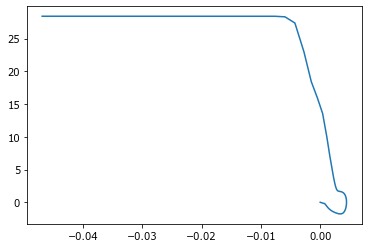

In [12]:
plt.figure(2)
plt.cla()
plt.plot(rnAll[250::2,0,0],vnAll[250::2,0,0])

C:\Users\klab\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  
C:\Users\klab\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


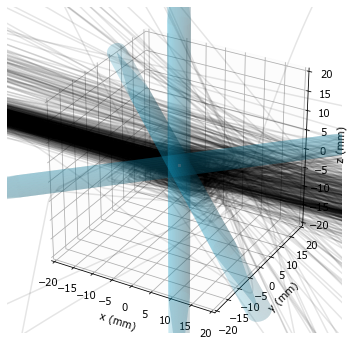

In [13]:
beamlen = 60
plotSize = 60
balpha = 0.08
fig = plt.figure(3, figsize=[6,6])
plt.cla()
ax = fig.gca(projection='3d')
ax.set_xlim([-20,20])
ax.set_ylim([-20,20])
ax.set_zlim([-20,20])
motSim.plotBeams(ax, kis, plotSize, 2*beamlen, beamWidth=w0*(1e3), colors=np.repeat('#1BAAD5',6), alpha=0.12)
for i in range(Natoms):
    ax.plot(rnAll[::10,0,i]*(1e3), rnAll[::10,1,i]*(1e3), rnAll[::10,2,i]*(1e3), color='k', alpha=0.1)
    ax.scatter(rnAll[-1,0,i]*(1e3), rnAll[-1,1,i]*(1e3), rnAll[-1,2,i]*(1e3), c='#CC4129', s=2, alpha=0.5)
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')
ax.w_xaxis.set_pane_color((0,0,0,0.01))
ax.w_yaxis.set_pane_color((0,0,0,0.01))
ax.w_zaxis.set_pane_color((0,0,0,0.01))

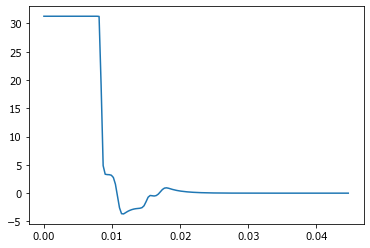

In [15]:
t = np.arange(0, dt*NtimeSteps, dt*10)
fig, ax = plt.subplots()
plt.plot(t,vnAll[::10,0,0])

In [435]:
x = np.linspace(-10e-3,10e-3,200)
z = x
FkbtestX = motSim.FMOT(m171, muEff, Gz, np.array([x, np.zeros_like(x), np.zeros_like(x)]),np.zeros((3,len(x))),kis[:-2])
# FkbtestZ = motSim.FMOT(m171, muEff, Gz, np.array([np.zeros_like(z), np.zeros_like(z), z]),np.zeros((3,len(z))),kis)
plt.figure(4)
plt.cla()
plt.plot(x, FkbtestX[0]/m171)
# plt.plot(z, FkbtestZ[2])

In [468]:
x = np.linspace(-20e-3,10e-3,200)
dfs = np.arange(-30,-10,2)
vx = 0
norm = mpl.colors.Normalize(vmin=dfs[0], vmax=dfs[-1]+5)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.plasma)
cmap.set_array([])
norm = mpl.colors.Normalize(vmin=dfs[0], vmax=0)
plt.figure(5)
plt.clf()
ax = fig.gca()
for df in dfs:
    dfG = df*gamma556
    kb1 = motSim.motBeam(k556*np.array([np.cos(theta_h), np.sin(theta_h), 0]), w0, np.zeros(3), gamma556, dfG, S556, 1)
    kb2 = motSim.motBeam(k556*np.array([-np.cos(theta_h), np.sin(theta_h), 0]), w0, np.zeros(3), gamma556, dfG, S556, 1)
    kb3 = motSim.motBeam(k556*np.array([np.cos(theta_h), -np.sin(theta_h), 0]), w0, np.zeros(3), gamma556, dfG, S556, 1)
    kb4 = motSim.motBeam(k556*np.array([-np.cos(theta_h), -np.sin(theta_h), 0]), w0, np.zeros(3), gamma556, dfG, S556, 1)
    kb5 = motSim.motBeam(k556*np.array([0, 0, 1]), w0vert, np.zeros(3), gamma556, dfG, S556vert, -1)
    kis = np.array([kb1, kb2, kb3, kb4, kb5])
    FkbtestX = motSim.FMOT(m171, muEff, Gz, np.array([x, np.zeros_like(x), np.zeros_like(x)]),
                          np.array([vx*np.ones_like(x), np.zeros_like(x), np.zeros_like(x)]),kis)
    plt.plot(x*(1e3), FkbtestX[0]/m171, color=cmap.to_rgba(df))
plt.xlabel('x (mm)')
plt.ylabel('Fx/m171')
cbar = plt.colorbar(cmap)
cbar.ax.set_ylabel('detuning ($\Gamma$)')
plt.title('vx = '+str(vx)+' m/s')

Text(0.5, 1.0, 'vx = 0 m/s')

In [273]:
inTrapped = ( np.sqrt(rnAll[-1,0,:]**2 + rnAll[-1,1,:]**2 + rnAll[-1,2,:]**2) < 4e-3 )
vnTrapped = vnAll[0,0,inTrapped]
vnYTrapped = vnAll[0,1,inTrapped]
vnZTrapped = vnAll[0,2,inTrapped]

In [276]:
plt.figure(6)
plt.cla()
plt.hist(vnAll[0,0,:],bins=np.arange(10,45), label='initial')
plt.hist(vnTrapped,bins=np.arange(10,45), label='captured');
plt.xlabel(r'$v_{x, init}$ (m/s)')
plt.ylabel('number atoms')
plt.legend()

In [74]:
fig, ax = plt.subplots()
plt.hist(vnAll[0,1,:],bins=np.arange(-0.5,0.5,0.1), label='initial')
plt.hist(vnYTrapped,bins=np.arange(-0.5,0.5,0.1), label='captured');
plt.xlabel(r'$v_{init,y}$ (m/s)')
plt.ylabel('number atoms')
plt.legend()

In [76]:
fig, ax = plt.subplots()
plt.hist(vnAll[0,2,:],bins=np.arange(-0.5,0.5,0.1), label='initial')
plt.hist(vnZTrapped,bins=np.arange(-0.5,0.5,0.1), label='captured');
plt.xlabel(r'$v_{init,z}$ (m/s)')
plt.ylabel('number atoms')
plt.legend()

In [45]:
t = 0.3/30
g = 10
dz = 0.5*(t**2)*g
dz*(1e6)

500.0

In [90]:
fig, ax = plt.subplots()
plt.hist(vnAll[-1,0,:],bins=np.arange(-35,35), label='final')
plt.xlabel(r'$v_{final}$ (m/s)')
plt.ylabel('number atoms')
plt.legend()

In [60]:
t = 0.3/30
vt = np.sqrt(0.5*sc.k*(2.5e-3)/m171)
vt*t

0.002465724061101375

In [107]:
90-np.arctan(169.05/362.5)*180/np.pi

64.99825074232679

In [46]:
x = np.linspace(-1,1,100)
plt.figure(6)
plt.cla()
plt.plot(x, np.heaviside(x+0.5,0.5)*np.heaviside(-x+0.5,0.5))